# Process Stations

In [5]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pkg_resources import resource_filename

from climpyrical.gridding import transform_coords, find_element_wise_nearest_pos
from scipy.interpolate import NearestNDInterpolator

### Load station data for processing

In [48]:
# df_path = '/home/nannau/nrc_data/Interim_snow_rain_load_LR_composite_stations_delivered_v3.csv'
# df_path = '/home/nannau/nrc_data/Interim_hdd_Tmax_Tmin_delivered.csv'
# df_path = '/home/nannau/nrc_data/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
# df_path = '/home/nannau/nrc_data/sl50_from_swe50_sdmax_lrs_composite_mss.csv'
# df_path = resource_filename('climpyrical', 
#                             '/nrc_data/janT2.5p_T1.0p_allstations_v2_for_maps.csv')

# df_path = resource_filename('climpyrical', 
#                             '/nrc_data/janT2.5p_T1.0p_allstations_min8yr_for_maps.csv')

df_path = resource_filename('climpyrical', 
                            '/nrc_data/wpress_stations_rl10_rl50.csv')

df = pd.read_csv(df_path, index_col=None).dropna()

df_zero = pd.read_csv(df_path, index_col=None)

# station_dv = 'RL50 (kPa)'
# station_dv = 'SL50 (kPa)'
# station_dv = 'TJan2.5 (degC)'

# station_dv = 'HDD (degC-day)'
station_dv = 'Q10_Gumbel-MM'

# transform into rotated pole and assign as new columns
rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values)

df = df.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)

df[station_dv] = df[station_dv].values# + 273.15
file_dv = station_dv.split(' ')[0]


# df_zero = df.copy()

# df = df[df[station_dv] != 0.0]
df.head(3)

/home/nannau/tri/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,Unnamed: 0,Unnamed: 0.1,Climate_ID,station_name,prov,elev,lat,lon,yrcount,yrstart,...,CoV,Gumbel 50-yr from formula,GUM 50 X adj. Factor,Gumbel 10-yr from formula,GUM 10 X adj. Factor,W10 / W50,Q10_Gumbel-MM,Q50_Gumbel-MM,rlon,rlat
0,0,0,1012710,ESQUIMALT HARBOUR,BC,3.0,48.431972,-123.439333,24.0,1994.0,...,0.09,70.0,76.0,63.0,69,0.91,0.200,0.244,-17.223584,3.866472
1,1,1,1016640,RACE ROCKS,BC,7.4,48.297984,-123.531441,23.0,1995.0,...,0.12,118.0,118.0,104.0,104,0.89,0.544,0.693,-17.325740,3.760133
2,2,2,1017101,SATURNA ISLAND CS,BC,24.4,48.783907,-123.044745,22.0,1995.0,...,0.10,110.0,110.0,99.0,99,0.90,0.487,0.605,-16.861117,4.113823


### Open the pre-processed model

In [49]:
# dv = 'Rain-RL50'
# dv = 'heating_degree_days_per_time_period'
dv = 'rl10'
# dv = 'snw'
# dv = 'tas'

pre_processed_path = resource_filename(
    "climpyrical", 
    "/nrc_data/processed/pre_processed.nc"
)

ds = xr.open_dataset(pre_processed_path)
np.nanmean(ds[dv].values)

0.3495104948884222

In [50]:
df

,Unnamed: 0,Unnamed: 0.1,Climate_ID,station_name,prov,elev,lat,lon,yrcount,yrstart,...,CoV,Gumbel 50-yr from formula,GUM 50 X adj. Factor,Gumbel 10-yr from formula,GUM 10 X adj. Factor,W10 / W50,Q10_Gumbel-MM,Q50_Gumbel-MM,rlon,rlat
0,0,0,1012710,ESQUIMALT HARBOUR,BC,3.0,48.431972,-123.439333,24.0,1994.0,...,0.09,70.0,76.0,63.0,69,0.91,0.200,0.244,-17.223584,3.866472
1,1,1,1016640,RACE ROCKS,BC,7.4,48.297984,-123.531441,23.0,1995.0,...,0.12,118.0,118.0,104.0,104,0.89,0.544,0.693,-17.325740,3.760133
2,2,2,1017101,SATURNA ISLAND CS,BC,24.4,48.783907,-123.044745,22.0,1995.0,...,0.10,110.0,110.0,99.0,99,0.90,0.487,0.605,-16.861117,4.113823
3,3,3,1017254,SHERINGHAM POINT,BC,6.9,48.376694,-123.921028,22.0,1994.0,...,0.14,114.0,114.0,99.0,99,0.87,0.493,0.650,-17.544331,3.920433
4,4,4,1018598,VICTORIA UNIVERSITY CS,BC,60.1,48.457000,-123.304611,24.0,1994.0,...,0.09,37.0,48.0,34.0,43,0.90,0.057,0.070,-17.130742,3.860779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,362,362,8500398,BATTLE HARBOUR LOR,NL,9.4,52.250000,-55.600000,24.0,1959.0,...,0.14,137.0,137.0,119.0,119,0.87,0.709,0.940,24.383441,11.279867
363,363,363,8501101,CARTWRIGHT A,NL,14.3,53.682500,-57.041944,53.0,1964.0,...,0.10,113.0,113.0,102.0,102,0.90,0.517,0.638,22.892900,12.101795
364,364,364,8501131,CHURCHILL FALLS A,NL,439.5,53.561944,-64.106389,45.0,1969.0,...,0.11,73.0,83.0,65.0,74,0.89,0.212,0.265,19.127314,10.125734
365,365,365,8501900,GOOSE A,NL,48.8,53.316667,-60.416667,42.0,1976.0,...,0.13,89.0,93.0,78.0,82,0.88,0.302,0.393,21.254575,10.842920


### Match stations to grids in model
Find the nearest grid cells to the station locations

In [51]:
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values, 
            df.rlon.values, 
            df.rlat.values
)

matched_df = pd.DataFrame({'ilocy': iy, 'ilocx': ix, station_dv: df[station_dv], 'rlat':df.rlat, 'rlon':df.rlon, 'lat': df.lat, 'lon':df.lon, 'station_name':df.station_name})
matched_df = matched_df.groupby(['ilocy', 'ilocx'], as_index=False).agg({station_dv: 'mean', 'rlat':'mean', 'rlon':'mean', 'lat': 'mean', 'lon': 'mean', 'station_name': 'first'})

iy = matched_df.ilocy.values
ix = matched_df.ilocx.values
station_vals = matched_df[station_dv].values

In [52]:
# station_vals

In [53]:
print(station_vals.shape, df.shape)

(361,) (367, 25)


Identify locations where the closest grid cell falls on a invalid model value

In [54]:
nan_index = np.isnan(ds[dv].values[iy, ix])
ixnan, iynan = matched_df.ilocx.values[nan_index], matched_df.ilocy.values[nan_index]
ixnan, iynan

(array([], dtype=int64), array([], dtype=int64))

Create an interpolator that can find the nearest valid model value at these locations

In [55]:
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

model_nan = ~np.isnan(ds[dv])
model_vals = ds[dv].values[iy, ix]

f = NearestNDInterpolator(np.stack([rlon[model_nan], rlat[model_nan]]).T, ds[dv].values[model_nan])

Replace those invalid values with their nearest neighbor based on above interpolator.

In [56]:
model_vals[nan_index] = f(np.stack([rlon[iynan, ixnan], rlat[iynan, ixnan]]).T)

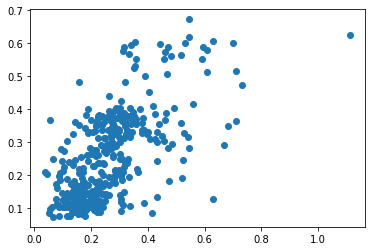

In [57]:
plt.scatter(station_vals, model_vals)

Now each station should be matched with a value grid cell value

In [58]:
ratio = matched_df[station_dv]/model_vals
assert not np.any(np.isnan(ratio))

### Normalize the model mean to match that of the station distribution
Find a factor, $\beta$ such that the model mean $$\frac{\mu_m}{\beta} \approx \mu_s$$ where $\mu_s$ is the station mean. 

0.1 <= 0.9721782053165933 < 2.916831354961439
New difference -2.6869213685529567e-05


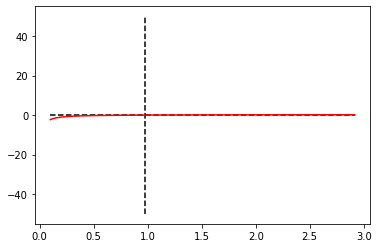

In [59]:
# choose starting value
# station_vals_no_0 = station_vals[station_vals != 0.0]
# model_vals_no_0 = model_vals[station_vals != 0.0]

start = np.nanmean(model_vals)/np. nanmean(station_vals)

# enter tolerances
tol = np.linspace(0.1, start*3, 10000)

diff = np.array([np.nanmean((station_vals - model_vals/t)) for t in tol])
# idx = np.argwhere(np.diff(np.sign(np.zeros(tol.shape) - diff))).flatten()
best_tol = tol[np.where(np.diff(np.sign(diff)))[0][0]]
# best_tol = tol[idx][0]

plt.plot(tol, diff, color='red')
plt.hlines(0, tol.min(), tol.max(), color='black', linestyle='--')
plt.vlines(best_tol, -50, 50, color='black', linestyle='--')
plt.plot()

# rmtols = np.array([np.nanmean(station_vals - (model_vals/t)) for t in tol])
# print(rmtols)
# best_tol = tol[np.where(np.diff(np.sign(rmtols)) != 0.)[0][0]]
# best_tol = 1.0
print(tol.min(), "<=", best_tol, "<", tol.max())

# apply correction
model_vals_corrected = model_vals/best_tol
mean_corrected = ds[dv].values/best_tol

ratio = (station_vals/model_vals_corrected)
# ratio = (station_vals-model_vals_corrected)/np.nanstd(mean_corrected)
# ratio = np.sqrt(-(station_vals-5))/np.sqrt(-(model_vals_corrected-5))


print("New difference", np.nanmean(station_vals - model_vals_corrected))

# calculate ratios with applied correction
matched_df = matched_df.assign(ratio=ratio)


In [60]:
matched_df = matched_df.assign(model_vals = model_vals, best_tol = best_tol)

In [61]:
# final_df = pd.concat([matched_df, df_zero[df_zero[station_dv] == 0.0]], sort=False)

In [62]:
# final_df.to_csv('./data/processed/processed_station.csv')
df_path_write = resource_filename('climpyrical', '/nrc_data/processed/processed_station.csv')
matched_df.to_csv(df_path_write)

matched_df.to_csv(f'/home/nannau/dash-dv-explorer/assets/data/stations/{file_dv}_stations.csv')

In [63]:
matched_df.head()

,ilocy,ilocx,Q10_Gumbel-MM,rlat,rlon,lat,lon,station_name,ratio,model_vals,best_tol
0,558,1009,0.275,-4.286303,10.373534,42.276111,-82.955278,WINDSOR A,0.891100,0.300021,0.972178
1,576,1016,0.298,-3.488044,10.709117,42.999444,-82.308889,SARNIA,0.917566,0.315736,0.972178
2,579,1050,0.287,-3.335369,12.206823,42.850000,-80.266667,SIMCOE,0.689214,0.404831,0.972178
3,580,1035,0.270,-3.290417,11.534369,43.033056,-81.151111,LONDON A,0.716656,0.366268,0.972178
4,587,1054,0.340,-2.967246,12.374482,43.173611,-79.935000,HAMILTON A,0.930399,0.355268,0.972178


In [64]:
matched_df[matched_df['ratio'] < 0]
np.any(ds[dv].values[ds[dv].values < 0])

/home/nannau/tri/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


False

# NRC Locations

In [65]:
nrc_path = '/home/nannau/nrc_data/NBCC_2020_new_coords.xlsm'
df_nrc = pd.read_excel(nrc_path).dropna()

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# get rotated pole coordinates
rlon_st, rlat_st = transform_coords(df_nrc['2020 Longitude'].values, df_nrc['2020 Latitude'].values)
df_nrc = df_nrc.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)

/home/nannau/tri/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [66]:
# find indices of the station locations
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values, 
            df_nrc.rlon.values, 
            df_nrc.rlat.values
)
# write to new dataframe
df_nrc_matched = pd.DataFrame(
    {'ilocy': iy, 
     'ilocx': ix, 
     'Location': df_nrc.Location, 
     'rlat':df_nrc.rlat, 
     'rlon':df_nrc.rlon, 
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
)

df_nrc_matched.to_csv('./data/processed/nrc_locations.csv')